In [243]:
# imports 
import re
import os
import json
import numpy as np
import scipy.stats as sci
import matplotlib.pyplot as pl
import matplotlib.ticker as mtick
import copy as cpy


In [244]:
# import sentiments as dictionary using re
file = open('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', 'r').read()
pattern = r'(\w*)\s*(\w*)\s*(\d)'
sentiments = {}

for word in re.findall(pattern, file):
    if int(word[2]) == 1:
        if word[0] in sentiments.keys():
            sentiments[word[0]].append(word[1])
        else: 
            sentiments[word[0]] = [word[1]]
print(sentiments)

{'abacus': ['trust'], 'abandon': ['fear', 'negative', 'sadness'], 'abandoned': ['anger', 'fear', 'negative', 'sadness'], 'abandonment': ['anger', 'fear', 'negative', 'sadness', 'surprise'], 'abba': ['positive'], 'abbot': ['trust'], 'abduction': ['fear', 'negative', 'sadness', 'surprise'], 'aberrant': ['negative'], 'aberration': ['disgust', 'negative'], 'abhor': ['anger', 'disgust', 'fear', 'negative'], 'abhorrent': ['anger', 'disgust', 'fear', 'negative'], 'ability': ['positive'], 'abject': ['disgust', 'negative'], 'abnormal': ['disgust', 'negative'], 'abolish': ['anger', 'negative'], 'abolition': ['negative'], 'abominable': ['disgust', 'fear', 'negative'], 'abomination': ['anger', 'disgust', 'fear', 'negative'], 'abort': ['negative'], 'abortion': ['disgust', 'fear', 'negative', 'sadness'], 'abortive': ['negative', 'sadness'], 'abovementioned': ['positive'], 'abrasion': ['negative'], 'abrogate': ['negative'], 'abrupt': ['surprise'], 'abscess': ['negative', 'sadness'], 'absence': ['fear

In [316]:
# sentiment analysis function
'''
json_object_structure = [{
    'time': str,
    'text': str, 
    'count': int,
    'sentiments' : {
        'sentiment': {
            'p':float, 
            'words': set[str]
        },
        'sentiment1': {
            'p':float, 
            'words': set[str]
        },
        'sentiment2': {
            'p':float, 
            'words':set[str]
        },
    }
}]
'''
# import chunks of text from transcripts and get sentiments
def sentiment_analysis(path: str, out:str, s_filters:list[str] or None = False, w_filters: list[str] or None = [], ):
    file = open(path, 'r')
    analysis = [] # output list of objects
    total = {} # words w/ sentiment in transcript
    t_count = 0 # total number of words w/ sentiment in entire transcript
    pattern = r'\b(\d+:\d+)\s*,\s*(\w+)\s*,\s*\"*(.*)\"*,*\n' # [time, name, text]
    for line in re.findall(pattern, file.read()):
        t_sentiments = {} # sentiment list for each paragraph 
        count = 0 # number of words w/ sentiment found in exerpt 

        # separate each word
        for word in re.findall(r'[\w\'\-]+', line[2]):
            if word in sentiments.keys() and word not in w_filters:
                count += 1
                # if word indicates sentiment count in dict
                for sentiment in sentiments[word]:
                    if sentiment not in t_sentiments.keys():
                        t_sentiments[sentiment] = {'p' : 1, 'words' : {word}}
                    else:
                        t_sentiments[sentiment]['p'] += 1
                        t_sentiments[sentiment]['words'].add(word)
            
        if s_filters: 
            # add totals to total list | no filter
                t_count += count
                for key in t_sentiments.keys():
                    if line[1] not in s_filters:
                        if key not in total.keys():
                            total[key] = {'p' : t_sentiments[key]['p'], 'words' : cpy.deepcopy(t_sentiments[key]['words'])}
                        else:
                            total[key]['p'] += t_sentiments[key]['p']
                            total[key]['words'] = list(t_sentiments[key]['words'].union(total[key]['words']))
                        # get proportion from total counts
                        t_sentiments[key]['p'] = t_sentiments[key]['p'] / count
                    t_sentiments[key]['words'] = list(t_sentiments[key]['words'])
        else: 
                # add totals to total list | no filter
                t_count += count
                for key in t_sentiments.keys():
                    if key not in total.keys():
                        total[key] = {'p' : t_sentiments[key]['p'], 'words' : cpy.deepcopy(t_sentiments[key]['words'])}
                    else:
                        total[key]['p'] += t_sentiments[key]['p']
                        total[key]['words'] = list(t_sentiments[key]['words'].union(total[key]['words']))
                    # get proportion from total counts
                    t_sentiments[key]['words'] = list(t_sentiments[key]['words'])
                    t_sentiments[key]['p'] = t_sentiments[key]['p'] / count
                

        analysis.append({
                        'speaker' : line[1],
                        'time' : line[0],
                        'text': line[2],
                        'count' : count,
                        'sentiments' : t_sentiments})
        
    # get total proportions 
    for key in total.keys():
        total[key]['p'] = total[key]['p'] / t_count
        total[key]['words'] = list(total[key]['words'])

    total['count'] = t_count

    analysis.append(total)
    file.close()
    file = open(out, 'w')
    json.dump(analysis, file)
 

In [318]:
# get all file names and generate analysis 
path = os.getcwd() + '\\transcripts'
transcripts = os.listdir(path)
pattern = r'(.+)\.csv'
s_filt = ["Eunice", "Caitlyn"]
w_filt = ["homelessness", "homeless"]
analysis = []
for transcript in transcripts:
    sentiment_analysis('transcripts\\' +  transcript,'analysis\\' +  re.findall(pattern, transcript)[0] + '.json', s_filters = s_filt , w_filters=w_filt)

In [319]:
# load all *.json in analysis folder to a list
path = os.getcwd() + '\\analysis'
a_paths = os.listdir(path)
print(a_paths)
analysis = []
for a_path in a_paths: 
    if a_path[-5:] == '.json':
        file = open(path + '\\' + a_path, 'r')
        try:
            analysis.append(json.load(file))
            file.close()
        except:
            print(a_path,"Cannot be parsed", file.read())
            file.close()

vr_filter = np.array([True, True, True, True, False, False, False, False, False, False, True, True, True, True,])
pre_filter = np.array([False, True, False, True, False, True, False, True, False, True, False, True, False, True,])

anger = np.array([sample[-1]['anger']['p'] if 'anger' in sample[-1].keys() else 0 for sample in analysis ])
anticipation = np.array([sample[-1]['anticipation']['p'] if 'anticipation' in sample[-1].keys() else 0 for sample in analysis ])
disgust = np.array([sample[-1]['disgust']['p'] if 'disgust' in sample[-1].keys() else 0 for sample in analysis ])
fear = np.array([sample[-1]['fear']['p'] if 'fear' in sample[-1].keys() else 0 for sample in analysis ])
joy = np.array([sample[-1]['joy']['p'] if 'joy' in sample[-1].keys() else 0 for sample in analysis ])
negative = np.array([sample[-1]['negative']['p'] if 'negative' in sample[-1].keys() else 0 for sample in analysis ])
positive = np.array([sample[-1]['positive']['p'] if 'positive' in sample[-1].keys() else 0 for sample in analysis ])
sadness = np.array([sample[-1]['sadness']['p'] if 'sadness' in sample[-1].keys() else 0 for sample in analysis ])
suprise = np.array([sample[-1]['suprise']['p'] if 'suprise' in sample[-1].keys() else 0 for sample in analysis ])
trust = np.array([sample[-1]['trust']['p'] if 'trust' in sample[-1].keys() else 0 for sample in analysis ])

counts = np.array([sample[-1]['count'] for sample in analysis ])


['2022_0205_Anika Post-Interview.json', '2022_0205_Anika_Pre Interview_A1_Transcript.json', '2022_0205_Jack_Post Interview_A1_Transcript.json', '2022_0205_Jack_Pre Interview_A1_Transcript.json', '2022_0205_James_Post Interview_A1_Transcript.json', '2022_0205_James_Pre Interview_A1_Transcript.json', '2022_0324_Ashlynn_Post_A1_Transcript.json', '2022_0324_Ashlynn_Pre_A1_Transcript.json', '2022_0324_Eevi_Post Interview_A1_Transcript.json', '2022_0324_Eevi_Pre Interview_A1_Transcript.json', '2022_0324_Maggi_Post Interview_Transcript.json', '2022_0324_Maggi_Pre Interview_A1_Transcript.json', '2022_0324_Ray_Post_A1_Transcript.json', '2022_0324_Ray_Pre_A1_Transcript.json', 'emotion_change']


In [414]:
# filter values and calculate pre-post difference 
# pre-sentiment values of 0 were replaced with arbitrary value of 1% 
d_emotions = {}
ttests = {}
post_anger = anger[~pre_filter]
pre_anger = anger[pre_filter]
pre_anger[pre_anger == 0] = np.mean(pre_anger) 
d_emotions["Anger"] = (post_anger - pre_anger) / pre_anger
ttests["Anger"] = sci.ttest_1samp(post_anger, np.mean(anger))

post_anticipation = anticipation[~pre_filter]
pre_anticipation = anticipation[pre_filter]
pre_anticipation[pre_anticipation == 0] = np.mean(pre_anticipation) 
d_emotions["Anticipation"] = (post_anticipation - pre_anticipation) / pre_anticipation
ttests["Anticipation"] = sci.ttest_1samp(post_anticipation, np.mean(anticipation))

post_disgust = disgust[~pre_filter]
pre_disgust = disgust[pre_filter]
pre_disgust[pre_disgust == 0] = np.mean(pre_disgust) 
d_emotions["Disgust"] = (post_disgust - pre_disgust) / pre_anticipation
ttests["Disgust"] = sci.ttest_1samp(post_disgust, np.mean(disgust))

post_fear = fear[~pre_filter]
pre_fear = fear[pre_filter]
pre_fear[pre_fear == 0] = np.mean(pre_fear) 
d_emotions["Fear"] = (post_fear - pre_fear) / pre_fear
ttests["Fear"] = sci.ttest_1samp(post_fear, np.mean(fear))

post_joy = joy[~pre_filter]
pre_joy = joy[pre_filter]
pre_joy[pre_joy == 0] = np.mean(pre_joy) 
d_emotions["Joy"] = (post_joy - pre_joy) / pre_joy
ttests["Joy"] = sci.ttest_1samp(post_joy, np.mean(joy))


post_sadness = sadness[~pre_filter]
pre_sadness = sadness[pre_filter]
pre_sadness[pre_sadness == 0] = np.mean(pre_sadness) 
d_emotions["Sadness"] = (post_sadness - pre_sadness) / pre_sadness
ttests["Sadness"] = sci.ttest_1samp(post_sadness, np.mean(sadness))

post_trust = trust[~pre_filter]
pre_trust = trust[pre_filter]
pre_trust[pre_trust == 0] = np.mean(pre_trust) 
d_emotions["Trust"] = (post_trust - pre_trust) / pre_trust
ttests["Trust"] = sci.ttest_1samp(post_trust, np.mean(trust))

post_negative = negative[~pre_filter]
pre_negative = negative[pre_filter]
pre_negative[pre_negative == 0] = np.mean(pre_negative) 
d_emotions["Negative"] = (post_negative - pre_negative) / pre_negative
ttests["Negative"] = sci.ttest_1samp(post_negative, np.mean(negative))

post_positive = positive[~pre_filter]
pre_positive = positive[pre_filter]
pre_positive[pre_positive == 0] = np.mean(pre_positive) 
d_emotions["Positive"] = (post_positive - pre_positive) / pre_positive
ttests["Positive"] = sci.ttest_1samp(post_positive, np.mean(positive))

print(ttests)


{'Anger': TtestResult(statistic=1.0854282486250797, pvalue=0.31940587072290805, df=6), 'Anticipation': TtestResult(statistic=0.5653466619792282, pvalue=0.5923335434805848, df=6), 'Disgust': TtestResult(statistic=-1.2514166367611212, pvalue=0.2573618089424113, df=6), 'Fear': TtestResult(statistic=0.9352206353105718, pvalue=0.38576925864313455, df=6), 'Joy': TtestResult(statistic=0.05676943309886836, pvalue=0.9565721663227302, df=6), 'Sadness': TtestResult(statistic=-1.2914565031143492, pvalue=0.244062849074969, df=6), 'Trust': TtestResult(statistic=0.5510184540701142, pvalue=0.6015203429040588, df=6), 'Negative': TtestResult(statistic=0.3868954680443021, pvalue=0.7121836254295506, df=6), 'Positive': TtestResult(statistic=0.1072547345937575, pvalue=0.9180833634453693, df=6)}
Anger 0.6442466171063158
Anticipation 0.3121320823951481
Disgust -0.5133953429561771
Fear 0.8465501438734739
Joy 0.7100401702455459
Sadness -0.35790595642112344
Trust 0.3254065975903586
Negative 0.31032058222341374
P

In [417]:
# tables of statistics
pseudonyms = np.array(['Anika','Jack', 'James', 'Ashlynn', 'Eevi', 'Maggi', 'Ray'])

# % Δ Emotion Proportion Between Pre and Post Interview
t_row = np.insert(pseudonyms, [0, len(pseudonyms)], ['Emotion', 'Mean'])
emo_column = np.array([key for key, value in d_emotions.items()], dtype="str_")
mean_column = np.array([np.mean(value) for key, value in d_emotions.items()])
vr_vid_row = np.array(['VR' if filt else 'Video' for filt in vr_filter[::2]])
table = np.stack([value for key, value in d_emotions.items()])
table = np.vstack([table.T, mean_column]).T

np.savetxt("analysis/emotion_change/values.csv", table, delimiter=",", fmt='%.4f')
np.savetxt("analysis/emotion_change/emotion_column.csv", emo_column, delimiter=",", fmt='%s')
np.savetxt("analysis/emotion_change/t_row.csv", t_row, delimiter=",", fmt='%s')
np.savetxt("analysis/emotion_change/vr_vid_row.csv", vr_vid_row, delimiter=",", fmt='%s')

# Mean % Δ Emotion Proportion Between Pre and Post Interview by VR vs Video
vr_vid_means = {'VR': np.array([]), 'Video': np.array([])}
for emotion, values in d_emotions.items():
    vr_vid_means['VR'] = np.append(vr_vid_means['VR'], np.mean(values[vr_filter[::2]]))
    vr_vid_means['Video'] = np.append(vr_vid_means['Video'], np.mean(values[~vr_filter[::2]]))

table = np.stack([vr_vid_means['VR'] , vr_vid_means['Video']])
t_row = emo_column

np.savetxt("analysis/vr_v_vid/values.csv", table, delimiter=',')
np.savetxt("analysis/vr_v_vid/t_row.csv", t_row, delimiter=",", fmt='%s')
np.savetxt("analysis/vr_v_vid/l_col.csv", np.array(['VR', 'Video']), delimiter=",", fmt='%s')

In [401]:
# ttests for count of emotionally charged 
post_count = counts[~pre_filter]
print('ttest for post counts',sci.ttest_1samp(post_count, np.mean(counts)))

ttest for post counts TtestResult(statistic=0.9349657893692583, pvalue=0.385890433105174, df=6)


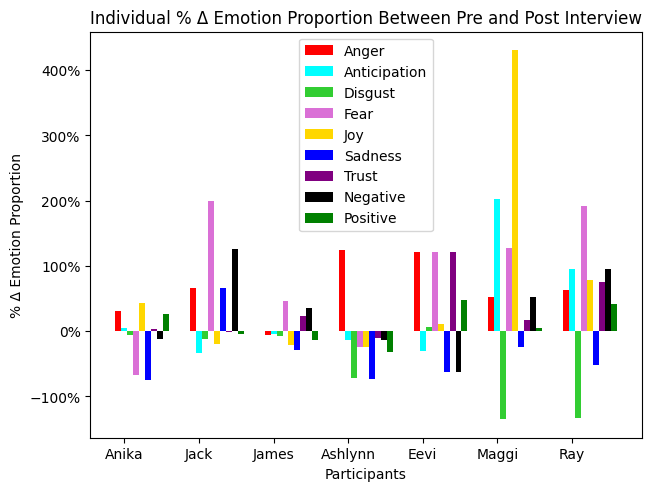

C:\Users\eloui\AppData\Local\Temp\ipykernel_79584\375213947.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(emo_labels, rotation=45, ha='right')


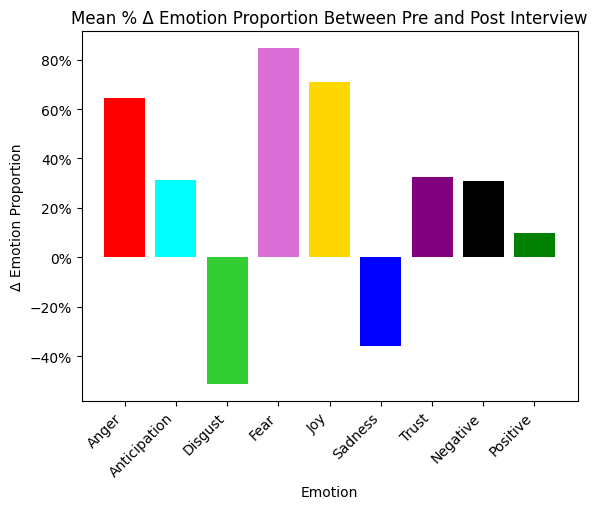

C:\Users\eloui\AppData\Local\Temp\ipykernel_79584\375213947.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(emo_labels, rotation=45, ha='right')


<Figure size 640x480 with 0 Axes>

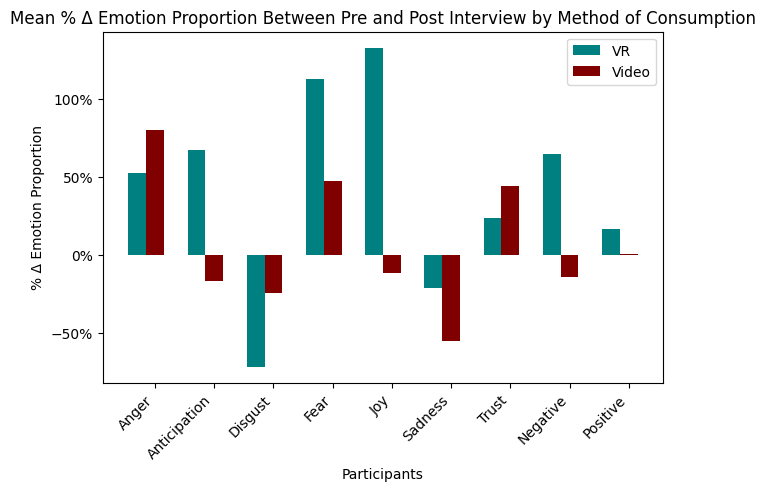

<Figure size 640x480 with 0 Axes>

In [402]:
# graphs for pre vs post emotions
colors = ['red', 'cyan', 'limegreen', 'orchid', 'gold', 'blue', 'purple', 'black', 'green']

# Graph of individual
x = np.arange(len(pseudonyms))
width = 0.08
multi = 0

fig, ax = pl.subplots(layout='constrained')

for emotion, values in d_emotions.items():
    offset = width * multi
    rects = ax.bar(x + offset, values, width, label=emotion, color=colors[multi])
    multi += 1

ax.set_ylabel(u'% Δ Emotion Proportion')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel('Participants')
ax.set_title(u'Individual % Δ Emotion Proportion Between Pre and Post Interview')
ax.legend()
ax.set_xticks(x + width, pseudonyms)

pl.show()
pl.clf()

# graph of means 
ax = pl.axes()
emo_labels = []
multi = 0

for emotion, values in d_emotions.items():
    ax.bar(emotion, np.mean(values), label = emotion, color=colors[multi])
    emo_labels.append(emotion)
    multi+=1

emo_labels = np.array(emo_labels)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xticklabels(emo_labels, rotation=45, ha='right')
ax.set_title(u'Mean % Δ Emotion Proportion Between Pre and Post Interview')
ax.set_ylabel(u'Δ Emotion Proportion')
ax.set_xlabel('Emotion')

pl.show()
pl.clf()

# means by VR vs Video
x = np.arange(len(emo_labels))
width = 0.3
multi = 0

fig, ax = pl.subplots(layout='constrained')

colors = ['teal', 'maroon']
for vr_vid, values in vr_vid_means.items():
    offset = width * multi
    rects = ax.bar(x + offset, values, width, label=vr_vid, color=colors[multi])
    multi += 1

ax.set_ylabel(u'% Δ Emotion Proportion')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel('Participants')
ax.set_title(u'Mean % Δ Emotion Proportion Between Pre and Post Interview by Method of Consumption')
ax.legend()
ax.set_xticklabels(emo_labels, rotation=45, ha='right')
ax.set_xticks(x + width, emo_labels)

pl.show()
pl.clf()
